<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/Novel_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Word2Vec Vectors from a novel in English

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
my_path="/content/drive/MyDrive/CS491/Data/"

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
import re
import gensim
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords if not already downloaded and convert to set for faster access
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# stop_words=set()##do not remove stop words


# Modify the regular expression for non-alphanumeric characters removal to also remove newlines, carriage returns, and tabs
non_alpha_numeric_re = re.compile('[\n\r\t]|[^a-zA-Z0-9\s]+')

def preprocess_text(text):
    # Use the compiled regex to remove non-alphanumeric characters except for spaces, and also newlines, carriage returns, and tabs
    text = non_alpha_numeric_re.sub(' ', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords using the set for faster lookup
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Return the preprocessed text
    return ' '.join(filtered_words).strip()

def prepare_for_w2v(filename_from, filename_to, lang='english', use_sentence_tokenization=True):
    with open(filename_from, "r", encoding='utf-8') as file:
        raw_text = file.read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        # Check if sentence tokenization is used
        if use_sentence_tokenization:
            sentences = nltk.sent_tokenize(raw_text, language=lang)
        else:
            sentences = [raw_text]  # Treat the entire text as a single sentence

        for sentence in sentences:
            processed_sentence = preprocess_text(sentence.lower())
            print(processed_sentence, file=f)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, vector_size=300, window=5, min_count=1, workers=4)  # Adjusted workers to 4 for potential parallel processing improvement


In [12]:
# Example usage with sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=True)

# Example usage without sentence tokenization
prepare_for_w2v(my_path+'The Golden Bowl', 'train_english_text.txt', 'english', use_sentence_tokenization=False)

model = train_word2vec('train_english_text.txt')

In [22]:
import numpy as np
from scipy.spatial.distance import cosine

def calculate_distance_to_line(point, line_start, line_end):
    # Calculate the line vector
    line_vector = line_end - line_start
    # Normalize the line vector
    line_vector_norm = line_vector / np.linalg.norm(line_vector)
    # Calculate the vector from the line_start to the point
    point_vector = point - line_start
    # Project point_vector onto line_vector
    projection_length = np.dot(point_vector, line_vector_norm)
    projection = projection_length * line_vector_norm
    # Calculate the distance from the point to the projection
    distance_vector = point_vector - projection
    distance = np.linalg.norm(distance_vector)
    return distance

# Vector for "he" and "she"
he_vector = model.wv['he']
she_vector = model.wv['she']

# Calculate the line direction vector
line_direction = he_vector - she_vector

# List to store words within eps distance
words_within_eps = []

for word in model.wv.key_to_index:
    # Skip "he" and "she" in the comparison
    if word in ['he', 'she']:
        continue

    word_vector = model.wv[word]
    distance = calculate_distance_to_line(word_vector, she_vector, he_vector)

    # If distance is within eps, add to list
    if distance <= 2.5:
        words_within_eps.append(word)

# Output the words within eps distance
len(words_within_eps)/ len(model.wv.key_to_index)


0.016521567075583696

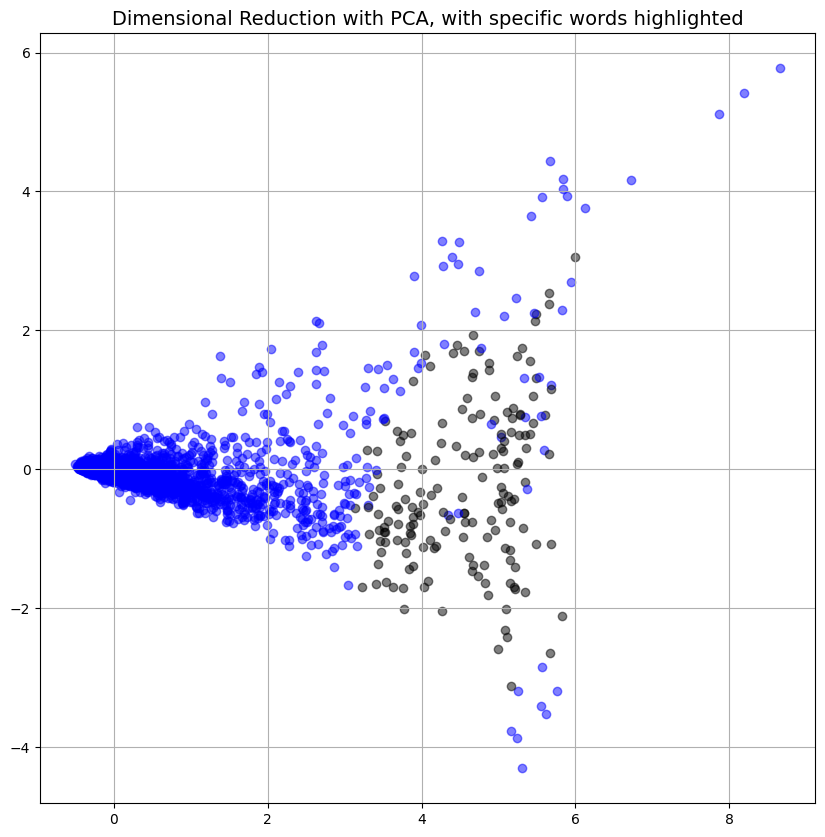

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your model and words_within_eps are loaded

# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors with color differentiation
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    color = 'black' if word in words_within_eps else 'blue'
    plt.scatter(reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1], color=color, alpha=0.5)

plt.title("Dimensional Reduction with PCA, with specific words highlighted", fontsize=14)
plt.grid(True)
plt.show()



In [25]:


# Function to retrieve words within specified boundaries
def get_words_in_plot_area(x_min, x_max, y_min, y_max, vectors, words):
    selected_words = []
    for i, (x, y) in enumerate(vectors):
        if x_min <= x <= x_max and y_min <= y <= y_max:
            selected_words.append(words[i])
    return selected_words



In [29]:
# Retrieve and print the words in the specified area
words_in_area = get_words_in_plot_area(3.5, 6, -3, 3, reduced_vectors_pca ,words)
print(words_in_area)

['to', 'it', 'her', 'she', 'and', 'that', 'had', 'was', 'as', 'he', 'for', 'with', 'at', 's', 'but', 'so', 'him', 'on', 'have', 'all', 'be', 'this', 'if', 'they', 'which', 'been', 'not', 'by', 'would', 'from', 'there', 'them', 'maggie', 'one', 'more', 'were', 'or', 'charlotte', 'might', 'then', 'could', 'out', 'up', 'is', 'little', 'even', 'than', 'said', 'much', 'made', 'only', 'herself', 'no', 'now', 'time', 'my', 'any', 'when', 'before', 'again', 'after', 'assingham', 'too', 'own', 'mrs', 'some', 'should', 'well', 'other', 'way', 'how', 'such', 'quite', 'come', 'yet', 'about', 'make', 'nothing', 'like', 'still', 'your', 'very', 'has', 'just', 'prince', 'something', 'really', 'never', 'while', 'father', 'into', 'always', 'who', 'back', 'fact', 'things', 'having', 'however', 'last', 'fanny', 'enough', 're', 'didn', 'himself', 'without', 'these', 'eyes', 'almost', 'everything', 'thing', 'take', 'being', 'must', 'good', 'felt', 'verver', 'oh', 'together', 'anything', 'less', 'first', 'a

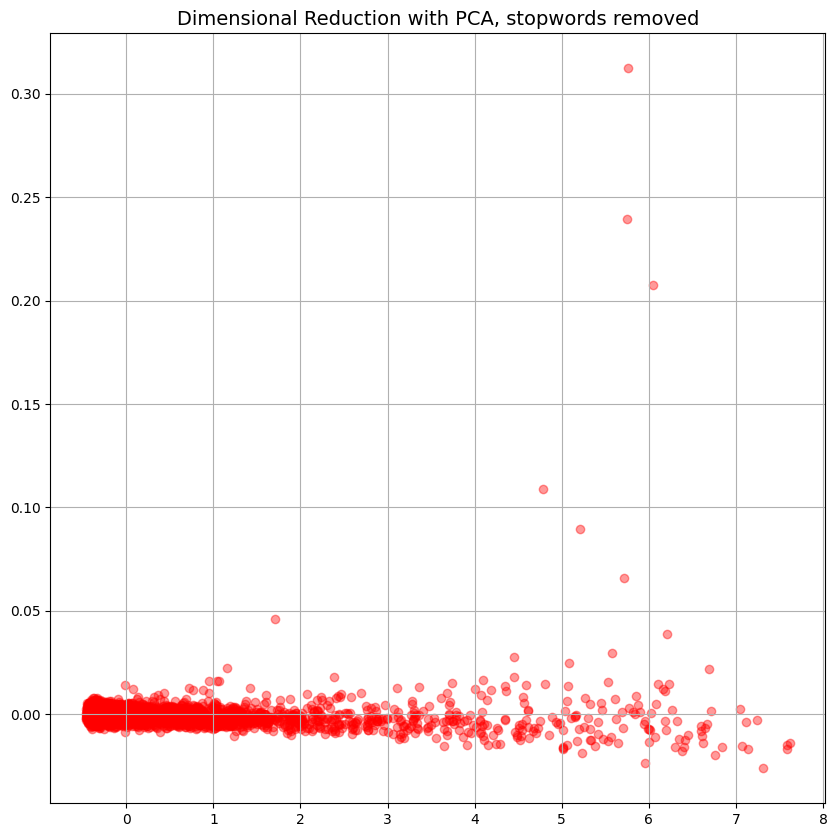

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
reduced_vectors_pca_yes = pca.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_pca_yes[i, 0], reduced_vectors_pca_yes[i, 1],color='red',alpha=0.4)

plt.title("Dimensional Reduction with PCA, stopwords removed", fontsize=14)
plt.grid(True)

plt.show()


In [ ]:
# Retrieve and print the words in the specified area
words_in_area = get_words_in_plot_area(1, 7, 0.05, 0.35, reduced_vectors_pca_yes, words)
print(words_in_area)

['said', 'assingham', 'mrs', 'fanny', 'verver', 'mr']


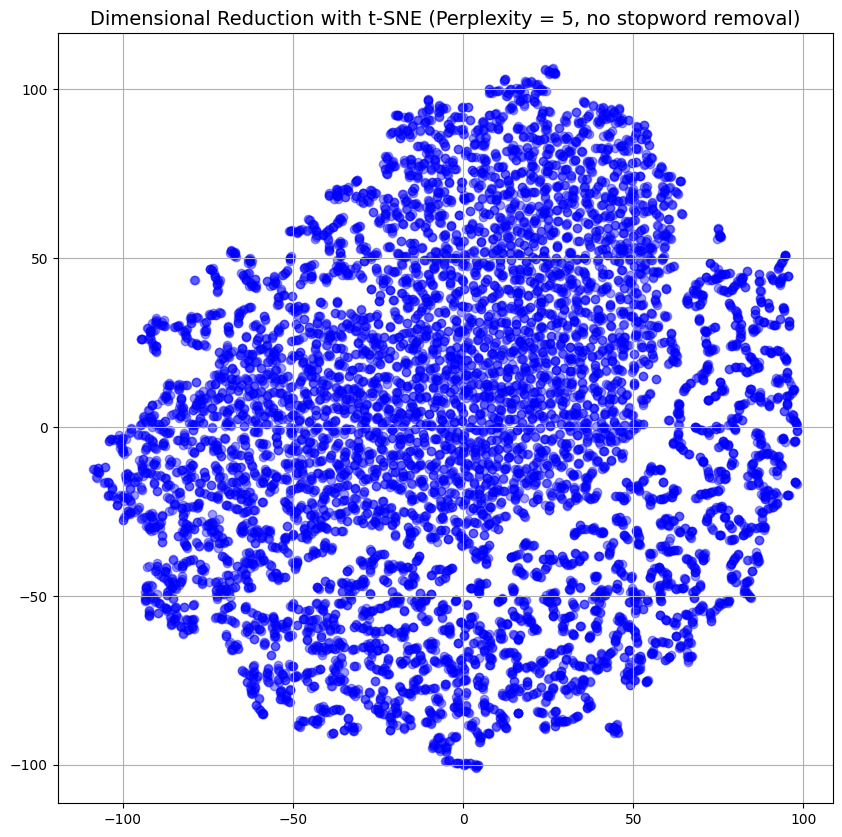

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply t-SNE with a specified perplexity value to reduce dimensions to 2
perplexity_value = 5  # Feel free to adjust this value
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_vectors_tsne_no = tsne.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors and include perplexity in the title
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_tsne_no[i, 0], reduced_vectors_tsne_no[i, 1], color='blue', alpha=0.4)

plt.title(f"Dimensional Reduction with t-SNE (Perplexity = {perplexity_value}, no stopword removal)", fontsize=14)
plt.grid(True)

plt.show()

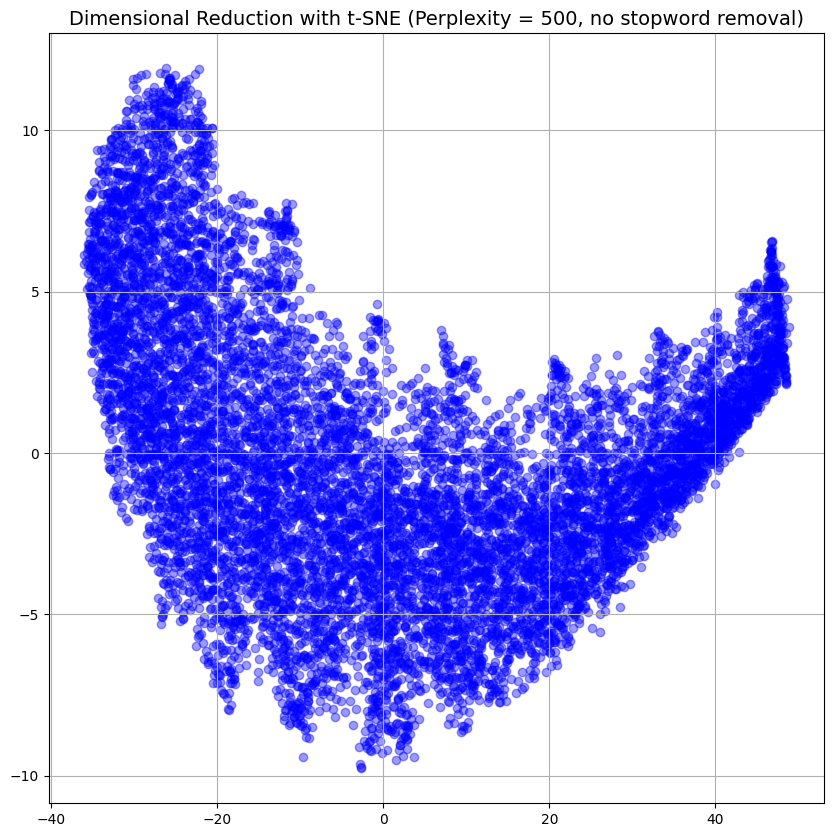

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply t-SNE with a specified perplexity value to reduce dimensions to 2
perplexity_value = 500  # Feel free to adjust this value
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_vectors_tsne_no = tsne.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors and include perplexity in the title
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_tsne_no[i, 0], reduced_vectors_tsne_no[i, 1], color='blue', alpha=0.4)

plt.title(f"Dimensional Reduction with t-SNE (Perplexity = {perplexity_value}, no stopword removal)", fontsize=14)
plt.grid(True)

plt.show()


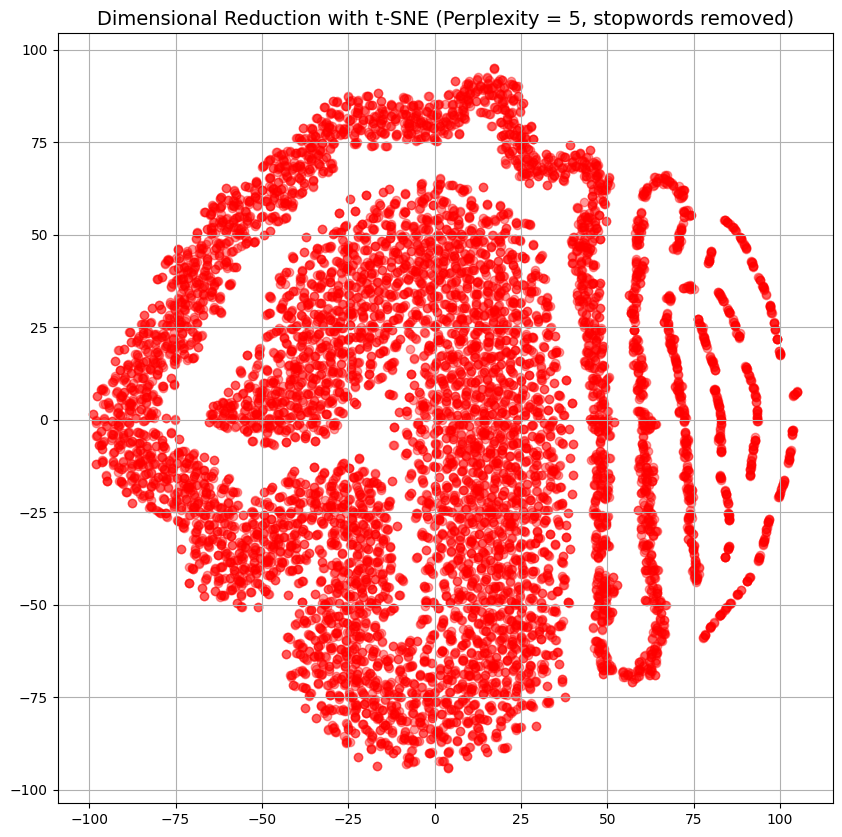

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply t-SNE with a specified perplexity value to reduce dimensions to 2
perplexity_value = 5  # Feel free to adjust this value
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_vectors_tsne_no = tsne.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors and include perplexity in the title
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_tsne_no[i, 0], reduced_vectors_tsne_no[i, 1], color='red', alpha=0.4)

plt.title(f"Dimensional Reduction with t-SNE (Perplexity = {perplexity_value}, stopwords removed)", fontsize=14)
plt.grid(True)

plt.show()


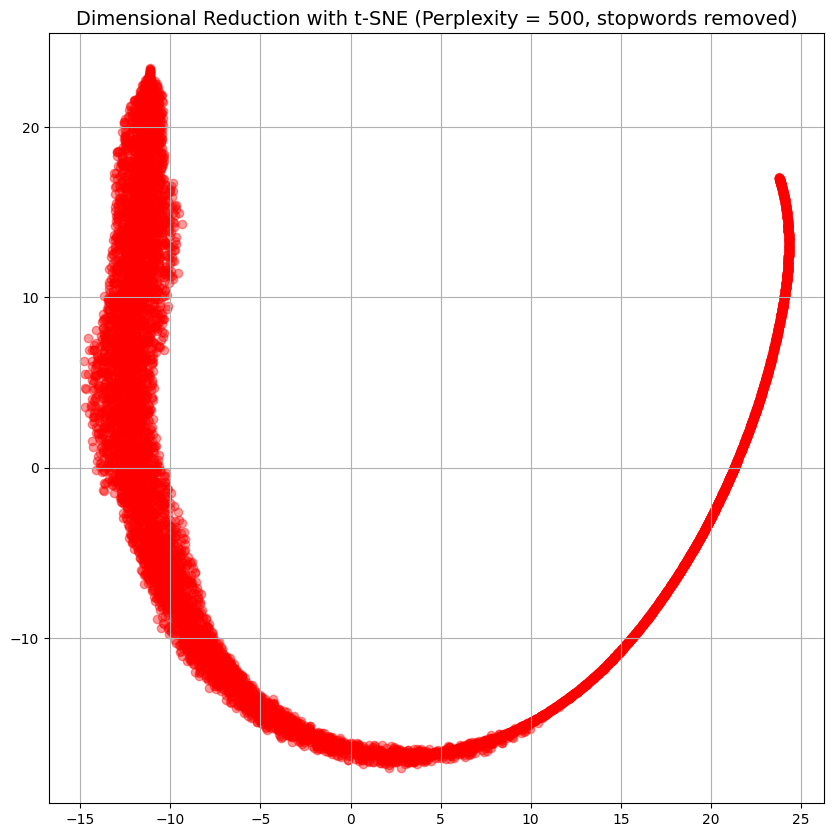

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply t-SNE with a specified perplexity value to reduce dimensions to 2
perplexity_value = 500  # Feel free to adjust this value
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_vectors_tsne_no = tsne.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors and include perplexity in the title
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_tsne_no[i, 0], reduced_vectors_tsne_no[i, 1], color='red', alpha=0.4)

plt.title(f"Dimensional Reduction with t-SNE (Perplexity = {perplexity_value}, stopwords removed)", fontsize=14)
plt.grid(True)

plt.show()


In [ ]:
!pip install umap-learn -q

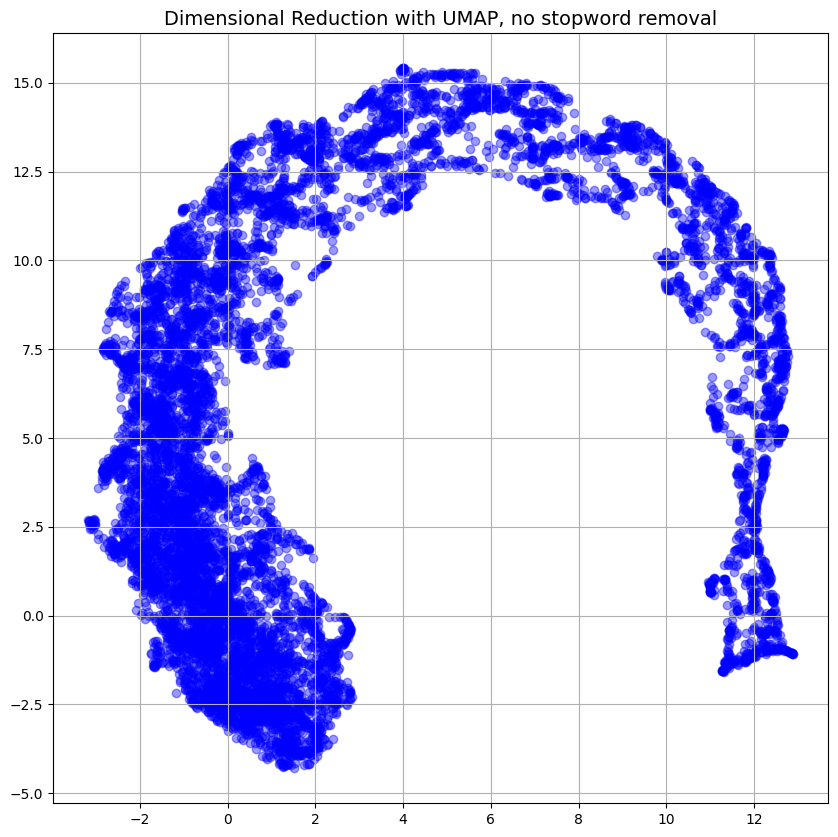

In [ ]:
import umap

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply UMAP to reduce dimensions to 2
# Note: UMAP has different parameters, n_neighbors and min_dist are commonly adjusted
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
reduced_vectors_umap_yes = umap_reducer.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_umap_yes[i, 0], reduced_vectors_umap_yes[i, 1], color='blue', alpha=0.4)
    # Uncomment the next line to display text labels beside each point
    # plt.text(reduced_vectors[i, 0]+0.03, reduced_vectors[i, 1]+0.03, word, fontsize=9)
plt.title("Dimensional Reduction with UMAP, no stopword removal", fontsize=14)
plt.grid(True)

plt.show()


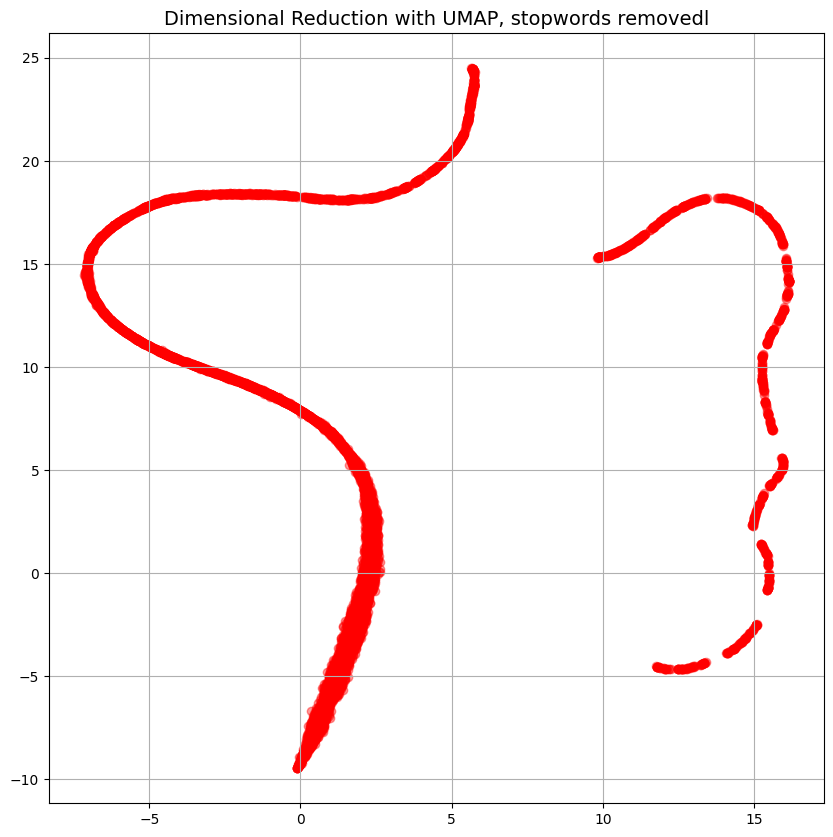

In [ ]:
import umap

# Step 1: Assuming your model is loaded in the variable `model`
# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply UMAP to reduce dimensions to 2
# Note: UMAP has different parameters, n_neighbors and min_dist are commonly adjusted
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
reduced_vectors_umap_no = umap_reducer.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors_umap_no[i, 0], reduced_vectors_umap_no[i, 1], color='red', alpha=0.4)
    # Uncomment the next line to display text labels beside each point
    # plt.text(reduced_vectors[i, 0]+0.03, reduced_vectors[i, 1]+0.03, word, fontsize=9)
plt.title("Dimensional Reduction with UMAP, stopwords removed", fontsize=14)
plt.grid(True)

plt.show()
